In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [60]:
df = pd.read_csv(r"C:\Users\A Esther Graceia\Downloads\survey.csv")

print("First 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

First 5 rows:
             Timestamp  Age  Gender         Country state self_employed  \
0  2014-08-27 11:29:31   37  Female   United States    IL           NaN   
1  2014-08-27 11:29:37   44       M   United States    IN           NaN   
2  2014-08-27 11:29:44   32    Male          Canada   NaN           NaN   
3  2014-08-27 11:29:46   31    Male  United Kingdom   NaN           NaN   
4  2014-08-27 11:30:22   31    Male   United States    TX           NaN   

  family_history treatment work_interfere    no_employees  ...  \
0             No       Yes          Often            6-25  ...   
1             No        No         Rarely  More than 1000  ...   
2             No        No         Rarely            6-25  ...   
3            Yes       Yes          Often          26-100  ...   
4             No        No          Never         100-500  ...   

                leave mental_health_consequence phys_health_consequence  \
0       Somewhat easy                        No                

## Data Preprocessing

In [61]:
for col in df.columns:
    df[col].fillna(df[col].mode()[0], inplace=True)


C:\Users\A Esther Graceia\AppData\Local\Temp\ipykernel_26420\1945806138.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
C:\Users\A Esther Graceia\AppData\Local\Temp\ipykernel_26420\1945806138.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

In [62]:
df['treatment'] = df['treatment'].map({'Yes': 1, 'No': 0})

In [63]:
df.drop(['Timestamp', 'Country', 'state', 'comments'], axis=1, inplace=True)

In [64]:
df = pd.get_dummies(df, drop_first=True)

In [65]:
print("\nData types after encoding:")
print(df.dtypes)

print("\nClass distribution:")
print(df['treatment'].value_counts())


Data types after encoding:
Age                          int64
treatment                    int64
Gender_Agender                bool
Gender_All                    bool
Gender_Androgyne              bool
                             ...  
phys_health_interview_No      bool
phys_health_interview_Yes     bool
mental_vs_physical_No         bool
mental_vs_physical_Yes        bool
obs_consequence_Yes           bool
Length: 91, dtype: object

Class distribution:
treatment
1    637
0    622
Name: count, dtype: int64


In [66]:
X = df.drop('treatment', axis=1)
y = df['treatment']

In [67]:
feature_names = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Test train split

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [69]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [70]:
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [71]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200,
                       random_state=42)

In [72]:
svm = SVC(kernel='rbf', C=1, gamma='scale')
svm.fit(X_train, y_train)

SVC(C=1)

In [73]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [74]:
y_pred_lr = lr.predict(X_test)
y_pred_dt = dt.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_svm = svm.predict(X_test)
y_pred_nb = nb.predict(X_test)

In [75]:
def evaluate(name, y_test, y_pred):
    print("Model:", name)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("------------------------")


In [76]:
evaluate("Logistic Regression", y_test, y_pred_lr)
evaluate("Decision Tree", y_test, y_pred_dt)
evaluate("Random Forest", y_test, y_pred_rf)
evaluate("SVM", y_test, y_pred_svm)
evaluate("Naive Bayes", y_test, y_pred_nb)

Model: Logistic Regression
Accuracy: 0.7261904761904762
Precision: 0.7565217391304347
Recall: 0.6796875
F1 Score: 0.7160493827160493
------------------------
Model: Decision Tree
Accuracy: 0.6865079365079365
Precision: 0.6842105263157895
Recall: 0.7109375
F1 Score: 0.6973180076628352
------------------------
Model: Random Forest
Accuracy: 0.7063492063492064
Precision: 0.7213114754098361
Recall: 0.6875
F1 Score: 0.704
------------------------
Model: SVM
Accuracy: 0.7261904761904762
Precision: 0.7478991596638656
Recall: 0.6953125
F1 Score: 0.7206477732793523
------------------------
Model: Naive Bayes
Accuracy: 0.5
Precision: 1.0
Recall: 0.015625
F1 Score: 0.03076923076923077
------------------------


In [77]:
print("\nOverfitting Check (Random Forest)")
print("Train Accuracy:", rf.score(X_train, y_train))
print("Test Accuracy:", rf.score(X_test, y_test))



Overfitting Check (Random Forest)
Train Accuracy: 0.9076464746772592
Test Accuracy: 0.7063492063492064


In [78]:
scores = cross_val_score(rf, X, y, cv=5)
print("\nCross Validation Score:", scores.mean())


Cross Validation Score: 0.732296211977487


In [79]:
cm = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix:\n", cm)


Confusion Matrix:
 [[90 34]
 [40 88]]


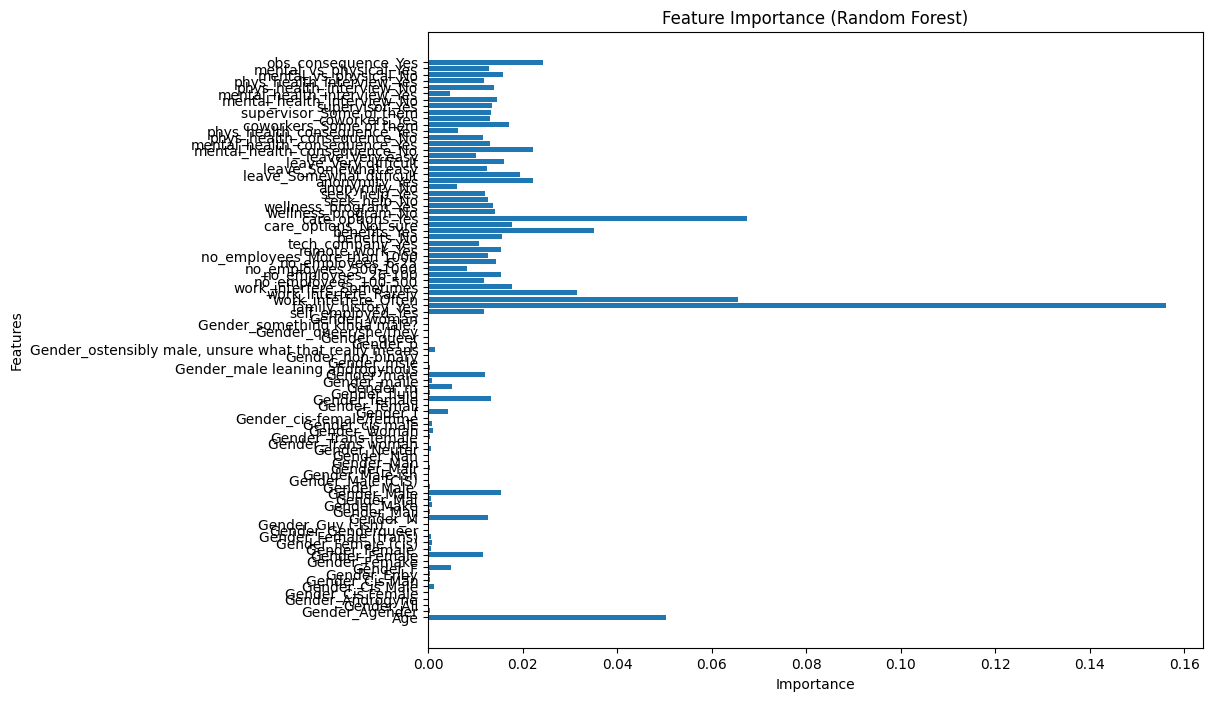

In [80]:
importances = rf.feature_importances_

plt.figure(figsize=(10, 8))
plt.barh(feature_names, importances)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance (Random Forest)")
plt.show()